In [1]:
import ot
import time
import random
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from model.utils import normalize, fiedler, smacof_mds, create_2D_class
from model.pwfunction import pw_barycenter

seed = 1
random.seed(seed)
np.random.seed(seed)

Import input cloud and create new samples

In [3]:
I = plt.imread("data/bird.png").astype(np.float64)[::30, ::30, 2]
n = I.shape[0]
XX, YY = np.meshgrid(np.arange(n), np.arange(n))
x = normalize(np.stack((XX[I == 0], -YY[I == 0]), 1) * 1.0)
print('Number of vertices of the first cloud: ', x.shape[0])
d = x.shape[1]
pivot_color = fiedler(x)

num_samples = 1
_, generated, colors = create_2D_class(x, pivot_color, num_samples=num_samples, noise=[.01,.02], rotate=True, seed=seed)
y = generated[0] @ np.array([[-1, 0], [0, 1]])
print('Number of vertices of the second cloud: ', y.shape[0])
dataset = [x , y]

Number of vertices of the first cloud:  404
Number of vertices of the second cloud:  462


Set hyper-parameters

In [5]:
measures_locations = dataset
measures_weights = [ot.unif(x.shape[0]) for x in dataset] # uniform distribution on samples


k = 400                                             # n. of barycenter's atoms
X_init = np.random.normal(0., 1., (k, d))           # Init barycenter atoms
b = ot.unif(k)                                      # uniform distribution on barycenter
importance_weights = ot.unif(num_samples + 1)       # weights of the samples 

# Compute different OT barycenters

In [7]:
# ---------------------------------------------------------------------
# 1 - Wasserstein barycenter
# ---------------------------------------------------------------------
start_time = time.time()
w_bar, log_w = ot.lp.free_support_barycenter(measures_locations, 
                                           measures_weights,
                                           X_init, b, 
                                           weights=importance_weights, 
                                           verbose=False, 
                                           log=True)

final_time = time.time()-start_time
print('Wasserstein barycenter : ---%s seconds---' % (final_time))

# ---------------------------------------------------------------------
# 2/3 - Gromow-Wasserstein barycenter (MDS & TSNE)
# ---------------------------------------------------------------------
C = [sp.spatial.distance.cdist(x, x) for x in measures_locations]
C = [c / c.max() for c in C]

start_time = time.time()
C_bar, log_gw = ot.gromov.gromov_barycenters(k, C, measures_weights, 
                                             b, importance_weights,
                                             max_iter=20, 
                                             tol=1e-3,
                                             log=True)

final_time = time.time()-start_time
print('Gromov-Wass. barycenter : ---%s seconds---' % (final_time))

gw_bar = smacof_mds(C_bar, d)
# step of Procrustes just for rotate as pivot cloud
U, E, Vh = np.linalg.svd(dataset[0].T @ log_gw['T'][0].T @ gw_bar)
P = U @ Vh
gw_bar_reg_MDS = gw_bar @ P

gw_bar_2 = TSNE(n_components=d, learning_rate='auto',
                init='random', perplexity=50.0).fit_transform(C_bar)
# step of Procrustes just for rotate as pivot cloud
U, E, Vh = np.linalg.svd(dataset[0].T @ log_gw['T'][0].T @ gw_bar_2)
P = U @ Vh
gw_bar_reg_TSNE = gw_bar_2 @ P

# ---------------------------------------------------------------------
# 4 - Procrustes-Wasserstein barycenter
# ---------------------------------------------------------------------
start_time = time.time()
pw_bar, log_pw = pw_barycenter(measures_locations, 
                            measures_weights,
                            X_init, b, 
                            weights=importance_weights, 
                            init_method='fiedler',
                            numItermax=20,
                            stopThr=1e-10,
                            verbose=False, 
                            log=True)

final_time = time.time()-start_time
print('Procrustes-Wass. barycenter : ---%s seconds---' % (final_time))
# rotate as pivot cloud
P1 = log_pw['procrustes'][0]
pw_bar_reg = pw_bar @ P1.T

Wasserstein barycenter : ---0.4005298614501953 seconds---
Gromov-Wass. barycenter : ---3.244532823562622 seconds---
Procrustes-Wass. barycenter : ---2.6486263275146484 seconds---


Visualize results

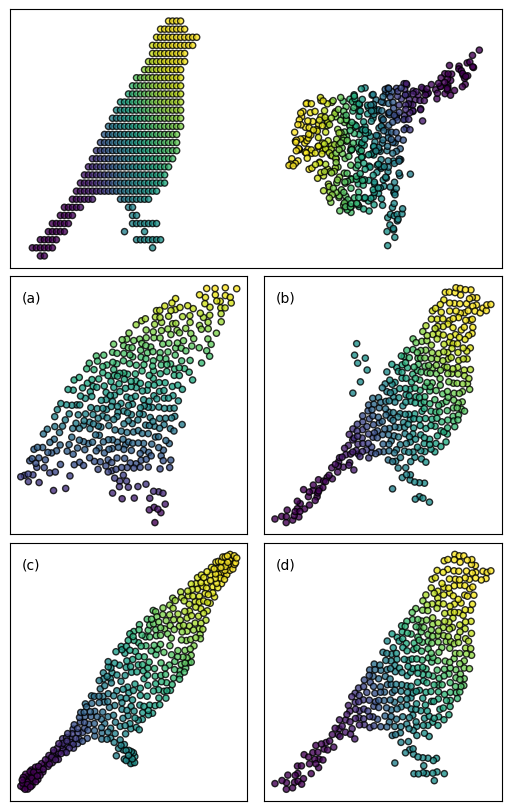

In [15]:
first_column = np.full((y.shape[0], 1), 2)
second_column = np.zeros((y.shape[0], 1))
shift = np.hstack((first_column, second_column))
y_ = y + shift
X = np.concatenate((x,y_))
X_color = np.concatenate((pivot_color, colors[0]))

fig = plt.figure(figsize=(5,8), constrained_layout=True)
ax = fig.add_subplot(3, 2, (1,2))
ax.scatter(X[:, 0], X[:, 1], s=20, c=X_color, edgecolors="k", alpha=.8)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(3, 2, 3)
ax.scatter(w_bar[:, 0], w_bar[:, 1], s=20, c=w_bar[:, 1], edgecolors="k", alpha=.8)
ax.text(0.05, 0.9, '(a)', transform=ax.transAxes, fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(3, 2, 4)
ax.scatter(gw_bar_reg_MDS[:, 0], gw_bar_reg_MDS[:, 1], s=20, c=pivot_color@log_gw['T'][0].T, edgecolors="k", alpha=.8)
ax.text(0.05, 0.9, '(b)', transform=ax.transAxes, fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(3, 2, 5)
ax.scatter(gw_bar_reg_TSNE[:, 0], gw_bar_reg_TSNE[:, 1], s=20, c=pivot_color@log_gw['T'][0].T, edgecolors="k", alpha=.8)
ax.text(0.05, 0.9, '(c)', transform=ax.transAxes, fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(3, 2, 6)
ax.scatter(pw_bar_reg[:, 0], pw_bar_reg[:, 1], s=20, c=pivot_color@log_pw['transport_plans'][0].T, edgecolors="k", alpha=.8)
ax.text(0.05, 0.9, '(d)', transform=ax.transAxes, fontsize=10)
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('fig/OTbarycenters.pdf', bbox_inches='tight', format="pdf")
plt.show()